# Transaction Anomalies Detection Using SOM

In [181]:
import sagemaker
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import torch
import torch.nn.functional as F
from sagemaker.pytorch import PyTorch
from sagemaker.pytorch import PyTorchModel
import os
import boto3
import seaborn as sns
import time
from sagemaker.local import LocalSession
import logging
import io

## Setup

In [182]:
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

In [183]:
model_dir = '/opt/ml/model'
# os.makedirs(model_dir, exist_ok = True)
os.environ["SM_MODEL_DIR"] = model_dir
os.environ["SM_CHANNEL_TRAINING"] = "/opt/ml/input/data/training"

In [184]:
# Create the directory with root privileges
!sudo mkdir -p $model_dir

# Set the directory permissions to allow the current user to write to it
!sudo chown -R $(whoami):$(whoami) $model_dir

# Verify that the directory was created with the correct permissions
!ls -l /opt/ml

total 0
drwxr-xr-x 2 root     root     36 Apr  6 18:20 metadata
drwxr-xr-x 2 ec2-user ec2-user  6 Apr 10 04:21 model


In [185]:
s3 = boto3.client('s3')
dir_path = "./path/on/local/filesystem"
file_name = "flagright-test-transactions-flattened.json"
file_path = dir_path + "/" + file_name
bucket = "flagright-test-transactions"
data_key = "transactions_json/flagright-test-transactions-flattened.json"
s3.download_file(bucket, data_key, file_path)

## Data Preprocessing

In [186]:
with open(file_path, 'r') as f:
    data = f.read()

# Load the JSON data into a Python object
json_data = json.loads(data)

In [187]:
for row in json_data:
    if len(row) == 9:
        print(row.keys())
        print(row)
        break

dict_keys(['destinationAmountDetails', 'transactionState', 'originAmountDetails', 'timestamp', 'transactionId', 'originUserId', 'destinationUserId', 'destinationPaymentDetails', 'originPaymentDetails'])
{'destinationAmountDetails': {'country': 'IN', 'transactionCurrency': 'INR', 'transactionAmount': 400000}, 'transactionState': 'CREATED', 'originAmountDetails': {'country': 'IN', 'transactionCurrency': 'INR', 'transactionAmount': 400000}, 'timestamp': {'$numberLong': '1662358001644'}, 'transactionId': '12b97d4eb51940d0886f609903fb2154', 'originUserId': '2f6ec341-9075-4aaa-9db2-9fd5d8597f97', 'destinationUserId': '0b85951b-c817-499e-ad17-453e5feaf87c', 'destinationPaymentDetails': {'method': 'GENERIC_BANK_ACCOUNT'}, 'originPaymentDetails': {'method': 'GENERIC_BANK_ACCOUNT'}}


In [188]:
# Flatten the data from a distributed structure
# Fill in the NaN's with 0's - treat them as unsuccessful transactions
json_data_flattened = []
for row in json_data:
    row_flattened = []
    row_flattened.append(row.get("destinationAmountDetails", {}).get("country", "UNK_LOC"))
    row_flattened.append(row.get("destinationAmountDetails", {}).get("transactionCurrency", "UNK_CUR"))
    row_flattened.append(row.get("originAmountDetails", {}).get("country", "UNK_LOC"))
    row_flattened.append(row.get("originAmountDetails", {}).get("transactionCurrency", "UNK_CUR"))
    row_flattened.append(row.get("transactionState", "UNK_STATE"))
    row_flattened.append(row.get("destinationPaymentDetails", {}).get("method", "UNK_ACCT"))
    row_flattened.append(row.get("originPaymentDetails", {}).get("method", "UNK_ACCT"))
    row_flattened.append(row.get("transactionId", "UNK_TRANSC"))
    row_flattened.append(row.get("originUserId", "UNK_ID"))
    row_flattened.append(row.get("destinationUserId", "UNK_ID"))
    row_flattened.append(row.get("destinationAmountDetails", {}).get("transactionAmount", 0))
    row_flattened.append(row.get("originAmountDetails", {}).get("transactionAmount", 0))
    row_flattened.append(row.get("timestamp", {}).get("$numberLong", 0))
    json_data_flattened.append(row_flattened)

In [189]:
json_data_flattened[:3]

[['IN',
  'INR',
  'IN',
  'INR',
  'CREATED',
  'GENERIC_BANK_ACCOUNT',
  'GENERIC_BANK_ACCOUNT',
  'bd70fcaebc254c23b07b29fd994ba5f2',
  '29529892-22d3-4a74-b6f2-fbe1d5ee8b6f',
  'UNK_ID',
  10132.8,
  10132.8,
  '1662358419786'],
 ['IN',
  'INR',
  'IN',
  'INR',
  'CREATED',
  'GENERIC_BANK_ACCOUNT',
  'GENERIC_BANK_ACCOUNT',
  'c9f8913d0bd548838e97bd6a609dbc45',
  '0b85951b-c817-499e-ad17-453e5feaf87c',
  'UNK_ID',
  145653.93,
  145653.93,
  '1662358416274'],
 ['IN',
  'INR',
  'IN',
  'INR',
  'CREATED',
  'GENERIC_BANK_ACCOUNT',
  'GENERIC_BANK_ACCOUNT',
  '4de9f33636cf44378f748f723ee4ac87',
  '29529892-22d3-4a74-b6f2-fbe1d5ee8b6f',
  'UNK_ID',
  6311,
  6311,
  '1662358117131']]

In [190]:
# Convert data into dataframe
df_flattened = pd.DataFrame(data=json_data_flattened, columns=["destination_country",\
                                                               "destination_currency",\
                                                               "origin_country",\
                                                               "origin_currency",\
                                                               "transaction_state",\
                                                               "destination_account",\
                                                               "origin_account",\
                                                               "transaction_id",\
                                                               "origin_user_id",\
                                                               "destination_user_id",\
                                                               "destination_amount",\
                                                               "origin_amount",\
                                                               "timestamp"])
df_flattened.head()

,destination_country,destination_currency,origin_country,origin_currency,transaction_state,destination_account,origin_account,transaction_id,origin_user_id,destination_user_id,destination_amount,origin_amount,timestamp
0,IN,INR,IN,INR,CREATED,GENERIC_BANK_ACCOUNT,GENERIC_BANK_ACCOUNT,bd70fcaebc254c23b07b29fd994ba5f2,29529892-22d3-4a74-b6f2-fbe1d5ee8b6f,UNK_ID,10132.80,10132.80,1662358419786
1,IN,INR,IN,INR,CREATED,GENERIC_BANK_ACCOUNT,GENERIC_BANK_ACCOUNT,c9f8913d0bd548838e97bd6a609dbc45,0b85951b-c817-499e-ad17-453e5feaf87c,UNK_ID,145653.93,145653.93,1662358416274
2,IN,INR,IN,INR,CREATED,GENERIC_BANK_ACCOUNT,GENERIC_BANK_ACCOUNT,4de9f33636cf44378f748f723ee4ac87,29529892-22d3-4a74-b6f2-fbe1d5ee8b6f,UNK_ID,6311.00,6311.00,1662358117131
3,IN,INR,IN,INR,CREATED,GENERIC_BANK_ACCOUNT,GENERIC_BANK_ACCOUNT,12b97d4eb51940d0886f609903fb2154,2f6ec341-9075-4aaa-9db2-9fd5d8597f97,0b85951b-c817-499e-ad17-453e5feaf87c,400000.00,400000.00,1662358001644
4,IN,INR,IN,INR,CREATED,GENERIC_BANK_ACCOUNT,GENERIC_BANK_ACCOUNT,32c6bc06f67b4e2b8222f76c8268cea9,0b85951b-c817-499e-ad17-453e5feaf87c,UNK_ID,45.00,45.00,1662357941739


In [191]:
# Raw data without scaling & feature engineering
df_numerical = df_flattened[["timestamp", "destination_amount"]]
df_numerical.head()

,timestamp,destination_amount
0,1662358419786,10132.80
1,1662358416274,145653.93
2,1662358117131,6311.00
3,1662358001644,400000.00
4,1662357941739,45.00


## Exploratory Data Analysis

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<AxesSubplot:xlabel='timestamp', ylabel='destination_amount'>

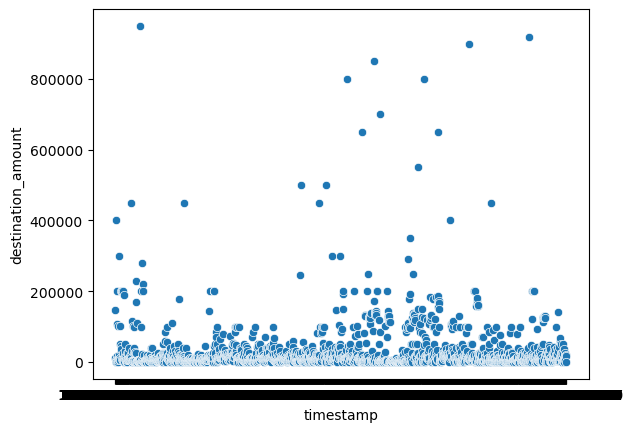

In [192]:
# Visualize data in a 2d plot
sns.scatterplot(data=df_numerical, x="timestamp", y="destination_amount")

In [193]:
# Standardized the data (important in distance-based clustering algorithms)
scaler = StandardScaler().fit(df_numerical)
df_normalized = scaler.transform(df_numerical)
df_normalized = pd.DataFrame(data=df_normalized, columns=["timestamp", "destination_amount"])
df_normalized.head()

,timestamp,destination_amount
0,2.129817,-0.290034
1,2.129738,1.462499
2,2.122952,-0.339457
3,2.120333,4.751652
4,2.118974,-0.420487


<AxesSubplot:xlabel='timestamp', ylabel='destination_amount'>

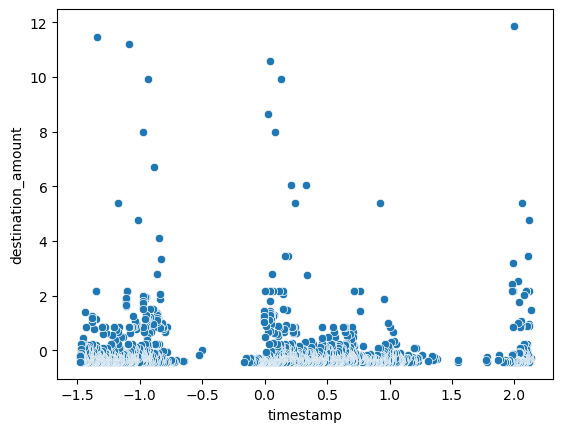

In [194]:
# Visualize the standardized data (still maintain similar pattern)
sns.scatterplot(data=df_normalized, x="timestamp", y="destination_amount")

/tmp/ipykernel_2818/2269436605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical["label"] = clustering.labels_
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<AxesSubplot:xlabel='timestamp', ylabel='destination_amount'>

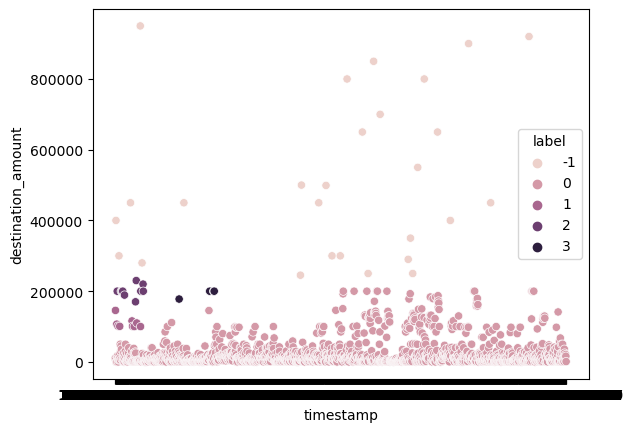

In [195]:
# DBSCAN clustering result shows a low dimensionality in raw data
# need for feature augmentation!
clustering = DBSCAN(eps=0.5, min_samples=5).fit(df_normalized)
df_numerical["label"] = clustering.labels_
sns.scatterplot(data=df_numerical, x="timestamp", y="destination_amount", hue="label")

<AxesSubplot:xlabel='timestamp', ylabel='destination_amount'>

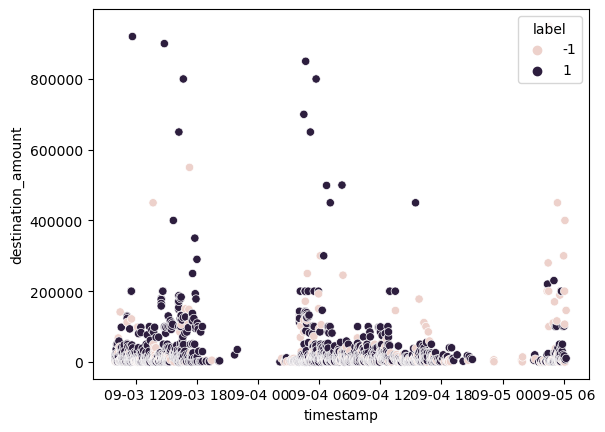

In [201]:
clf = LocalOutlierFactor(n_neighbors=3)
df_numerical["label"] = clf.fit_predict(df_normalized)
sns.scatterplot(data=df_numerical, x="timestamp", y="destination_amount", hue="label")

## Feature Engineering

In [197]:
# Create more features from datetime column

df_features = df_flattened[["transaction_id", "destination_user_id", "origin_user_id", "destination_amount", "timestamp"]]
df_features["timestamp"] = pd.to_datetime(df_features["timestamp"], unit='ms')
df_features = df_features.sort_values(by=["timestamp"])

# Extract various date and time related features using the dt accessor
df_features['hour_of_day'] = df_features['timestamp'].dt.hour
df_features['day_of_week'] = df_features['timestamp'].dt.dayofweek

# Normalize the values and calculate sine and cosine
df_features['normalized_hour'] = df_features['hour_of_day'] / 24.0
df_features['normalized_day'] = df_features['day_of_week'] / 7.0

# Normalize the values and calculate sine and cosine
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['normalized_hour'])
df_features['day_sin'] = np.sin(2 * np.pi * df_features['normalized_day'])

df_features = df_features.drop(columns=['hour_of_day', 'day_of_week', 'normalized_hour', 'normalized_day'])

# set timestamp column as index
df_features.set_index('timestamp', inplace=True)
df_features.head()

/tmp/ipykernel_2818/1901746365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["timestamp"] = pd.to_datetime(df_features["timestamp"], unit='ms')


,transaction_id,destination_user_id,origin_user_id,destination_amount,hour_sin,day_sin
timestamp,,,,,,
2022-09-03 10:00:25.580,184393274689832409735689685527027658086,18c93a66-2bd3-4441-8857-9a8384386aa3,UNK_ID,1015.0,0.5,-0.974928
2022-09-03 10:00:32.727,b8d19de4d49245cca45b7a5060618c05,UNK_ID,29529892-22d3-4a74-b6f2-fbe1d5ee8b6f,16074.0,0.5,-0.974928
2022-09-03 10:01:41.531,710fce1fb8fa4da1aac66a9040799112,UNK_ID,29529892-22d3-4a74-b6f2-fbe1d5ee8b6f,20727.0,0.5,-0.974928
2022-09-03 10:03:32.645,322113873786649356714350252684046334548,68d44d8a-cb77-4293-bb79-4fbc53bd93ff,UNK_ID,5000.0,0.5,-0.974928
2022-09-03 10:04:28.414,311429435255244075508140947161258421208,9fa40961-e989-4b40-8d40-78816ccde6b0,UNK_ID,17901.0,0.5,-0.974928


In [198]:
# Perform feature engineering by constructing features on grouped-by sliding whindows
destination_sliding_mean = df_features.groupby("destination_user_id")["destination_amount"]\
.rolling(window="1D").mean().reset_index().sort_values(by=["timestamp"])["destination_amount"]
destination_prefix_mean = \
df_features.groupby("destination_user_id")["destination_amount"].expanding().mean().reset_index().sort_values(by=["timestamp"])["destination_amount"]
origin_sliding_mean = df_features.groupby("origin_user_id")["destination_amount"]\
.rolling(window="1D").mean().reset_index().sort_values(by=["timestamp"])["destination_amount"]
origin_prefix_mean = \
df_features.groupby("origin_user_id")["destination_amount"].expanding().mean().reset_index().sort_values(by=["timestamp"])["destination_amount"]
df_features["destination_sliding_mean"] = list(destination_sliding_mean)
df_features["destination_prefix_mean"] = list(destination_prefix_mean)
df_features["origin_sliding_mean"] = list(origin_sliding_mean)
df_features["origin_prefix_mean"] = list(origin_prefix_mean)
df_features["destination_sliding_mean_diff"] = df_features["destination_amount"] - df_features["destination_sliding_mean"]
df_features["destination_prefix_mean_diff"] = df_features["destination_amount"] - df_features["destination_prefix_mean"]
df_features["origin_sliding_mean_diff"] = df_features["destination_amount"] - df_features["origin_sliding_mean"]
df_features["origin_prefix_mean_diff"] = df_features["destination_amount"] - df_features["origin_prefix_mean"]
df_features.drop(columns=["destination_sliding_mean", "destination_prefix_mean", "origin_sliding_mean", "origin_prefix_mean"], inplace=True)
df_features.head()

,transaction_id,destination_user_id,origin_user_id,destination_amount,hour_sin,day_sin,destination_sliding_mean_diff,destination_prefix_mean_diff,origin_sliding_mean_diff,origin_prefix_mean_diff
timestamp,,,,,,,,,,
2022-09-03 10:00:25.580,184393274689832409735689685527027658086,18c93a66-2bd3-4441-8857-9a8384386aa3,UNK_ID,1015.0,0.5,-0.974928,0.0,0.0,0.0,0.0
2022-09-03 10:00:32.727,b8d19de4d49245cca45b7a5060618c05,UNK_ID,29529892-22d3-4a74-b6f2-fbe1d5ee8b6f,16074.0,0.5,-0.974928,0.0,0.0,0.0,0.0
2022-09-03 10:01:41.531,710fce1fb8fa4da1aac66a9040799112,UNK_ID,29529892-22d3-4a74-b6f2-fbe1d5ee8b6f,20727.0,0.5,-0.974928,2326.5,2326.5,2326.5,2326.5
2022-09-03 10:03:32.645,322113873786649356714350252684046334548,68d44d8a-cb77-4293-bb79-4fbc53bd93ff,UNK_ID,5000.0,0.5,-0.974928,0.0,0.0,1992.5,1992.5
2022-09-03 10:04:28.414,311429435255244075508140947161258421208,9fa40961-e989-4b40-8d40-78816ccde6b0,UNK_ID,17901.0,0.5,-0.974928,0.0,0.0,9929.0,9929.0


In [199]:
df_numerical = df_features.iloc[:, 3:]
cols = df_numerical.columns
scaler = StandardScaler().fit(df_numerical)
df_normalized = scaler.transform(df_numerical)
df_normalized = pd.DataFrame(data=df_normalized, columns=cols)
clf = LocalOutlierFactor(n_neighbors=5)
print(clf.fit_predict(df_normalized))

[ 1  1  1 ...  1 -1  1]


In [200]:
# The final feature matrix (set requires_grad to False since we don't need gradient descent in SOM)
X = torch.tensor(df_normalized.values, dtype=torch.float32, requires_grad=False)
X

tensor([[-0.4079,  0.5123, -0.7472,  ...,  0.0358,  0.0102,  0.0134],
        [-0.2132,  0.5123, -0.7472,  ...,  0.0358,  0.0102,  0.0134],
        [-0.1530,  0.5123, -0.7472,  ...,  0.0812,  0.0542,  0.0572],
        ...,
        [-0.3395,  1.2285,  3.2937,  ..., -0.4263, -0.3299, -0.4284],
        [ 1.4625,  1.2285,  3.2937,  ...,  2.2872,  1.1256,  0.7626],
        [-0.2900,  1.2285,  3.2937,  ..., -0.3542, -0.2525, -0.3534]])

In [172]:
# Upload the final features to S3 bucket
os.makedirs("./data", exist_ok = True)
df_normalized.to_csv("./data/df_normalized.csv")
prefix = 'pytorch'
data_input_path = sess.upload_data('data/df_normalized.csv', key_prefix=prefix)
print(data_input_path)

s3://sagemaker-us-east-2-216657257678/pytorch/df_normalized.csv


## Model Training

In [173]:
# Define the hyperparameters
hyperparameters = {"batch-size": 1, "epochs": 20, "learning-rate": 0.1}

# Define the PyTorch estimator
estimator = PyTorch(entry_point="som-train.py",\
                    role=role,\
                    framework_version="1.8.1",
                    py_version="py3",\
                    instance_count=1,\
                    instance_type="local",\
                    hyperparameters=hyperparameters)

# Train the model
estimator.fit({"data-dir": data_input_path})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-19-17-51-36-172
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-zs41y:
    command: train
    container_name: 9cc12pqk62-algo-1-zs41y
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-training

Creating 9cc12pqk62-algo-1-zs41y ... 
Creating 9cc12pqk62-algo-1-zs41y ... done
Attaching to 9cc12pqk62-algo-1-zs41y
9cc12pqk62-algo-1-zs41y | 2023-04-19 17:51:40,899 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
9cc12pqk62-algo-1-zs41y | 2023-04-19 17:51:40,904 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
9cc12pqk62-algo-1-zs41y | 2023-04-19 17:51:40,916 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
9cc12pqk62-algo-1-zs41y | 2023-04-19 17:51:40,930 sagemaker_pytorch_container.training INFO     Invoking user training script.
9cc12pqk62-algo-1-zs41y | 2023-04-19 17:51:41,141 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
9cc12pqk62-algo-1-zs41y | 2023-04-19 17:51:41,156 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
9cc12pqk62-algo-1-zs41y | 2023-04-19 17:51:41,168 sagemaker-training-toolkit 

9cc12pqk62-algo-1-zs41y | Training Progress: 0.0%
9cc12pqk62-algo-1-zs41y | [2023-04-19 17:51:45.872 algo-1-zs41y:26 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
9cc12pqk62-algo-1-zs41y | [2023-04-19 17:51:46.130 algo-1-zs41y:26 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
9cc12pqk62-algo-1-zs41y | Training Progress: 5.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 10.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 15.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 20.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 25.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 30.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 35.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 40.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 45.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 50.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 55.0%
9cc12pqk62-algo-1-zs41y | Training Progress: 60.0%
9cc12pqk62-algo-1-zs41y | 

INFO:root:creating /tmp/tmpdphdjeyl/artifacts/output/data
INFO:root:copying /tmp/tmpdphdjeyl/algo-1-zs41y/output/success -> /tmp/tmpdphdjeyl/artifacts/output
INFO:root:copying /tmp/tmpdphdjeyl/model/model.pth -> /tmp/tmpdphdjeyl/artifacts/model


===== Job Complete =====


## Model Deployment

In [180]:
# Create a SageMaker PyTorchModel object
model = PyTorchModel(model_data=estimator.model_data,
                     entry_point='inference.py',
                     role="arn:aws:iam::216657257678:role/service-role/AmazonSageMaker-ExecutionRole-20230330T185713",
                     framework_version='1.8.0',
                     py_version='py3')

# Deploy the PyTorchModel to an endpoint
predictor = model.deploy(instance_type='ml.t2.medium',
                          initial_instance_count=1)

INFO:sagemaker:Creating model with name: pytorch-inference-2023-04-19-18-39-36-746
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-04-19-18-39-37-458
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-04-19-18-39-37-458


------------!

## Cleanup

In [175]:
sess.delete_endpoint(predictor.endpoint_name)

INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-04-19-17-51-52-570
